# Probabilistic Elastic FWI

In this notebook we look at probabilistic elastic Full-Waveform Inversion. The example here is purposefully kept very small with only little data, to facilitate experimentation.

We will use the external package `psvWave`, which implements Virieux 1986's staggered FD scheme for P-SV wave propagation. Gradients are calculated using the adjoint method.

Note that the 'wheels' for psvWave are only guaranteed to work for Linux, on Python 3.7.

In [1]:
import hmclab
import matplotlib.pyplot as plt
import numpy
import psvWave

from mpl_toolkits.axes_grid1 import AxesGrid

First we start by creating some synthetic data. psvWave provides a basic setting in which one can run experiments. Let's load those settings and have a look at them:

In [2]:
fwi_settings = psvWave.fdModel.get_dictionary()

fwi_settings["domain"]["nx_inner"] = 20
fwi_settings["domain"]["nz_inner"] = 20

fwi_settings["domain"]["nx_inner_boundary"] = 0
fwi_settings["domain"]["nz_inner_boundary"] = 0

fwi_settings["boundary"]["np_boundary"] = 10

fwi_settings["sources"]["ix_sources"] = [2, 18]
fwi_settings["sources"]["iz_sources"] = [2, 2]
fwi_settings["receivers"]["ix_receivers"] = [4, 8, 12, 16]
fwi_settings["receivers"]["iz_receivers"] = [18, 18, 18, 18]

fwi_settings

{'domain': {'nt': 1000,
  'nx_inner': 20,
  'nz_inner': 20,
  'nx_inner_boundary': 0,
  'nz_inner_boundary': 0,
  'dx': 1.249,
  'dz': 1.249,
  'dt': 0.0002},
 'boundary': {'np_boundary': 10, 'np_factor': 0.015},
 'medium': {'scalar_rho': 1500.0, 'scalar_vp': 2000.0, 'scalar_vs': 800.0},
 'sources': {'peak_frequency': 50.0,
  'n_sources': 2,
  'n_shots': 1,
  'source_timeshift': 0.005,
  'delay_cycles_per_shot': 24,
  'moment_angles': [90, 180],
  'ix_sources': [2, 18],
  'iz_sources': [2, 2],
  'which_source_to_fire_in_which_shot': [[0, 1]]},
 'receivers': {'nr': 4,
  'ix_receivers': [4, 8, 12, 16],
  'iz_receivers': [18, 18, 18, 18]},
 'inversion': {'snapshot_interval': 10},
 'basis': {'npx': 1, 'npz': 1},
 'output': {'observed_data_folder': '.', 'stf_folder': '.'}}

We see that this simulation has two sources (moment tensors with Ricker wave STF's) that are on the 'bottom' of the medium. These are recorded by sources at the top. The medium is surrounded by an absorbing boundary. Let's compress the simulation a bit and shorten it by firing the sources close together:

In [3]:
fwi_settings["domain"]["nt"] = 1400
fwi_settings["sources"]["delay_cycles_per_shot"] = 6

Now we can create this simulation object with the requested settings:

In [4]:
psvWave.fdModel.write_dictionary("settings.ini", fwi_settings)

fdModel = psvWave.fdModel("settings.ini")

Loading configuration file: 'settings.ini'.
Parsing passed configuration.


We can plot the geometry of all shots by doing the following.

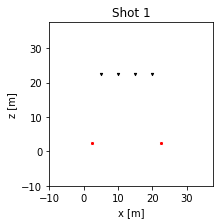

In [5]:
for i_shot in range(fdModel.n_shots):
    fdModel.plot_domain(shot_to_plot=i_shot)
    plt.title(f"Shot {i_shot+1}")
    plt.show()

To look how HMC works in this settings, we need an interesting model to test on. We create a target model below, which contains a spherical anomaly in P-wave velocity, S-wave velocity and density:

In [6]:
# Create target model
# Get the coordinates of every grid point
IX, IZ = fdModel.get_coordinates(True)
# Get the associated parameter fields
vp, vs, rho = fdModel.get_parameter_fields()

x_middle = (IX.max() + IX.min()) / 2
z_middle = (IZ.max() + IZ.min()) / 2

# Add a circular negative anomaly to the 'true' model
circle = ((IX - x_middle) ** 2 + (IZ - z_middle) ** 2) ** 0.5 < 5
vs = vs * (1 - 0.1 * circle)
vp = vp * (1 - 0.1 * circle)
rho = rho * (1 + 0.1 * circle)

vp_target = vp
vs_target = vs
rho_target = rho

Let's visualize this anomaly in all parameters:

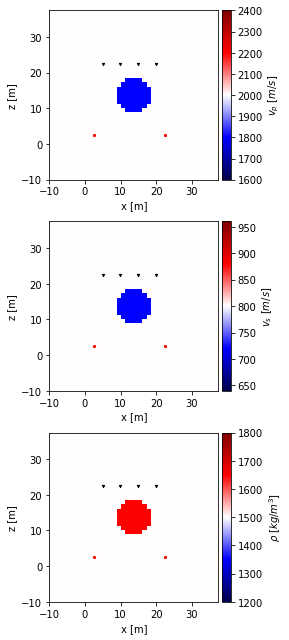

In [7]:
background_means = numpy.array([2000, 800, 1500])
percentage_deviation = 0.2
mins = background_means * (1 - percentage_deviation)
maxs = background_means * (1 + percentage_deviation)

fdModel.set_parameter_fields(vp_target, vs_target, rho_target)
fdModel.plot_fields(vmin=mins, vmax=maxs)
true_model = fdModel.get_model_vector()

In [8]:
%time fdModel.forward_simulate(0, omp_threads_override=6)

CPU times: user 157 ms, sys: 13.9 ms, total: 171 ms
Wall time: 28.7 ms


Let's create the 'observed' data with some noise:

(<Figure size 576x216 with 2 Axes>,
 array([[<AxesSubplot:title={'center':'horizontal displacement shot 0'}, xlabel='time [s]', ylabel='channel id'>,
         <AxesSubplot:title={'center':'vertical displacement shot 0'}, xlabel='time [s]', ylabel='channel id'>]],
       dtype=object))

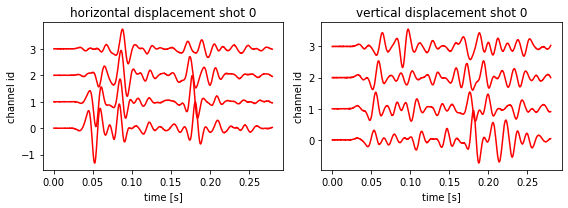

In [9]:
# Create 'true' data
# print("Faking observed data")
for i_shot in range(fdModel.n_shots):
    fdModel.forward_simulate(i_shot, omp_threads_override=6)

# Cheating of course, as this is synthetically generated data.
ux_obs, uz_obs = fdModel.get_synthetic_data()

numpy.random.seed(32312)
ux_obs += 25 * numpy.random.randn(*ux_obs.shape)
uz_obs += 25 * numpy.random.randn(*ux_obs.shape)

fdModel.plot_data(data=(ux_obs, uz_obs), exagerration=1)

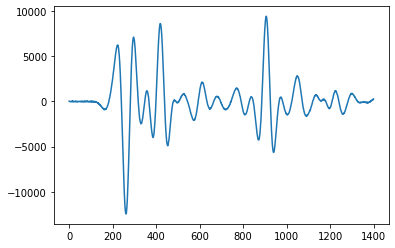

In [10]:
plt.plot(ux_obs[0, 0, :])

To get some intuition on what we are actually doing, we can plot the wavefield in the one shot at two different points in time. This is the wavefield of the 'true' data.

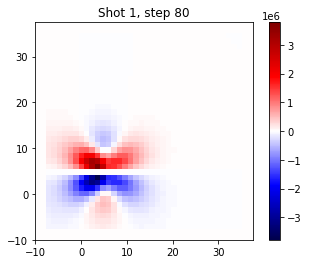

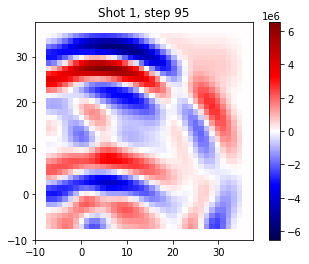

In [11]:
time_step = 10
plt.figure()
for i_shot in range(fdModel.n_shots):
    field = fdModel.get_snapshots()[0][i_shot, time_step, :, :]
    field_extr = numpy.max(numpy.abs(field))
    plt.imshow(
        numpy.flipud(field.T),
        vmin=-field_extr,
        vmax=field_extr,
        extent=fdModel.get_extent(True),
        cmap=plt.get_cmap("seismic"),
    )
    plt.colorbar()
    plt.title(f"Shot {i_shot+1}, step 80")
    plt.show()

time_step = 30
plt.figure()
for i_shot in range(fdModel.n_shots):
    field = fdModel.get_snapshots()[0][i_shot, time_step, :, :]
    field_extr = numpy.max(numpy.abs(field))
    plt.imshow(
        numpy.flipud(field.T),
        vmin=-field_extr,
        vmax=field_extr,
        extent=fdModel.get_extent(True),
        cmap=plt.get_cmap("seismic"),
    )
    plt.colorbar()
    plt.title(f"Shot {i_shot+1}, step 95")
    plt.show()

In [12]:
# sampler = hmclab.Samplers.HMC()

# posterior = hmclab.Distributions.ElasticFullWaveform2D(
#     "settings.ini",
#     ux_obs=ux_obs,
#     uz_obs=uz_obs,
#     omp_threads_override=6,
#     temperature=5**2,
# )

# posterior.update_bounds(
#     posterior.get_model_vector() - 200,
#     posterior.get_model_vector() + 200,
# )

# %rm samples.h5

# sampler.sample(
#     "samples.h5",
#     posterior,
#     autotuning=True,
#     initial_model=true_model[:,None],
#     amount_of_steps=10,
#     proposals=10000,
#     overwrite_existing_file=False,
# )

In [13]:
# Execute parallel sampling
parallel_sampler = hmclab.Samplers.ParallelSampleSMP()

samplers = [hmclab.Samplers.HMC() for i in range(2)]

filenames = [f"samples_fwi_parallel_{i}.h5" for i in range(2)]

temperatures = [1, 3]

posteriors = [
    hmclab.Distributions.ElasticFullWaveform2D(
        "settings.ini",
        ux_obs=ux_obs,
        uz_obs=uz_obs,
        omp_threads_override=1,
        temperature=(5.0 ** 2) * 1,
    )
    for temp in temperatures
]

for posterior in posteriors:
    posterior.update_bounds(
        posterior.get_model_vector() - 200,
        posterior.get_model_vector() + 200,
    )

initial_model = [
    true_model[:, None],
    true_model[:, None],
]

parallel_sampler.sample(
    samplers,
    filenames,
    posteriors,
    proposals=1000,
    overwrite_existing_files=True,
    initial_model=true_model[:, None],
)

Loading configuration file: 'settings.ini'.
Parsing passed configuration.
Loading configuration file: 'settings.ini'.
Parsing passed configuration.
Starting 2 markov chains...


sys:1: Warning: 
Silently overwriting samples file (samples_fwi_parallel_0.h5) if it exists.
sys:1: Warning: 
Silently overwriting samples file (samples_fwi_parallel_1.h5) if it exists.


enter
enter


Tab()

In [14]:
posteriors[0].set_model_vector(posteriors[0].get_model_vector())

In [15]:
for i, s in enumerate(parallel_sampler.samplers):
    pass

In [16]:
plt.plot(sampler.stepsizes)

NameError: name 'sampler' is not defined

In [ ]:
with hmclab.Samples("samples.h5") as samples:
    samples_n = samples.numpy

In [ ]:
for i in range(10):
    fdModel.plot_model_vector(samples_n[:-1, i * 100][:, None], vmin=mins, vmax=maxs)

In [ ]:
fdModel.plot_model_vector(
    #     posterior.blob.forward_transform_background(
    samples_n[:-1, :].mean(axis=1)[:, None],
    vmin=mins,
    vmax=maxs
    #     )
)

fdModel.plot_model_vector(
    #     posterior.blob.forward_transform_background(
    samples_n[:-1, :].std(axis=1)[:, None]
    #     )
)

In [ ]:
_ = plt.plot(samples_n[:-1, :].T)

In [ ]:
_ = plt.plot(samples_n[-1, :].T)

In [ ]:
m = samples_n[:-1, :].mean(axis=1)

In [ ]:
mf = m  # posterior.blob.forward_transform_background(m[:,None])

In [ ]:
vector_splits = numpy.split(mf, 3)

fields = fdModel.get_parameter_fields()
for i, field in enumerate(fields):
    field[:] = numpy.nan
    field[
        (fdModel.nx_inner_boundary + fdModel.np_boundary) : -(
            fdModel.nx_inner_boundary + fdModel.np_boundary
        ),
        (fdModel.nz_inner_boundary + fdModel.np_boundary) : -(
            fdModel.nz_inner_boundary + fdModel.np_boundary
        ),
    ] = (
        vector_splits[i]
        .reshape(
            (
                fdModel.nz_free_parameters,
                fdModel.nx_free_parameters,
            )
        )
        .T
    )

In [ ]:
from scipy.ndimage import gaussian_filter

sigma = 1.0

plt.figure()
plt.imshow(
    gaussian_filter(fields[0][10:-10, 10:-10], sigma),
    cmap=plt.get_cmap("seismic"),
    vmin=1800,
    vmax=2200,
)
plt.colorbar()
plt.figure()
plt.imshow(
    gaussian_filter(fields[1][10:-10, 10:-10], sigma),
    cmap=plt.get_cmap("seismic"),
    vmin=700,
    vmax=900,
)
plt.colorbar()
plt.figure()
plt.imshow(
    gaussian_filter(fields[2][10:-10, 10:-10], sigma),
    cmap=plt.get_cmap("seismic"),
    vmin=1350,
    vmax=1650,
)
plt.colorbar()

In [ ]:
import numpy as np

C = np.corrcoef(samples_n[:-1, :])

# C= np.cov(samples_n[:-1, :])

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(C[0:40, 0:40], vmin=-1, vmax=1, cmap=plt.get_cmap("seismic"))

In [ ]:
plt.imshow(C[250, :400].reshape(20, 20), vmin=-1, vmax=1, cmap=plt.get_cmap("seismic"))

In [ ]:
plt.semilogy(np.std(samples_n[:-1, :], axis=1))

In [ ]:
_ = plt.hist(samples_n[500, :], bins=100)